In [61]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
from sklearn.metrics import accuracy_score
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torch.nn.functional as F
import re
import torch
from torch.utils.data import Dataset
import threading
from transformers import BertModel, BertTokenizer, AutoModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import AutoTokenizer, DistilBertModel, AutoProcessor, Wav2Vec2Model, Swinv2Model, AutoImageProcessor
import librosa
from transformers import Swinv2Config, Swinv2Model
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import warnings
import math
import random
import threading
warnings.filterwarnings('ignore')

In [62]:
df = pd.read_csv('/kaggle/input/imocap-preprocess/train_label.csv')
train_X = df.iloc[:,:].values.tolist()
train_y = df.iloc[:,1].values.tolist()
for i in range(3709,3709+832):
    train_X.append([i,2])
    train_y.append(2)
train_y = np.array(train_y)
# print(train_y.shape)

val_df = pd.read_csv('/kaggle/input/imocap-preprocess/val_label.csv')
val_X = val_df.iloc[:,:].values.tolist()
val_y = val_df.iloc[:,1].values.tolist()
for i in range(464,464+104):
    val_X.append([i,2])
    val_y.append(2)
val_y = np.array(val_y)
# print(val_y.shape)

test_df = pd.read_csv('/kaggle/input/imocap-preprocess/test_label.csv')
test_X = test_df.iloc[:,:].values.tolist()
test_y = test_df.iloc[:,1].values.tolist()
for i in range(464,464+103):
    test_X.append([i,2])
    test_y.append(2)
test_y = np.array(test_y)
# print(test_y.shape[0] + val_y.shape[0] + train_y.shape[0])
train_data = TensorDataset(torch.Tensor(train_X).short(), torch.Tensor(train_y).short())
train_iter = DataLoader(train_data, batch_size = 16, shuffle=True)

val_data = TensorDataset(torch.Tensor(val_X).short(), torch.Tensor(val_y).short())
val_iter = DataLoader(val_data, batch_size = 8, shuffle = False)

test_data = TensorDataset(torch.Tensor(test_X).short(), torch.Tensor(test_y).short())
test_iter = DataLoader(test_data, batch_size = 8, shuffle = False)

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def trie(label_array, pred):
    ground_truth = torch.argmax( torch.clone(label_array), dim=1).cpu().detach().numpy().copy()
    pred_ind = torch.argmax( torch.clone(pred), dim=1).cpu().detach().numpy().copy()
    accuracy = accuracy_score(ground_truth, pred_ind)
    precision = precision_score(ground_truth, pred_ind, average="weighted")
    recall = recall_score(ground_truth,pred_ind, average="weighted")
    f1 = f1_score(ground_truth, pred_ind, average="weighted")
    return accuracy, precision, recall, f1    

In [64]:
pd_audio_train = pd.read_csv("/kaggle/input/imocap-preprocess/csv_audio_train_2.csv")
pd_audio_train = pd_audio_train.iloc[:,1:].values
pd_audio_train_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_audio_train_exc_2.csv")
pd_audio_train_exc = pd_audio_train_exc.iloc[:,1:].values
pd_audio_train = np.append(pd_audio_train, pd_audio_train_exc, axis = 0 )

pd_audio_val = pd.read_csv("/kaggle/input/imocap-preprocess/csv_audio_val_2.csv")
pd_audio_val = pd_audio_val.iloc[:,1:].values
pd_audio_val_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_audio_val_exc_2.csv")
pd_audio_val_exc = pd_audio_val_exc.iloc[:,1:].values
pd_audio_val = np.append(pd_audio_train, pd_audio_val_exc, axis = 0 )

pd_audio_test = pd.read_csv("/kaggle/input/imocap-preprocess/csv_audio_test_2.csv")
pd_audio_test = pd_audio_test.iloc[:,1:].values
pd_audio_test_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_audio_test_exc_2.csv")
pd_audio_test_exc = pd_audio_test_exc.iloc[:,1:].values
pd_audio_test = np.append(pd_audio_test, pd_audio_test_exc, axis = 0 )

pd_text_sos_train = pd.read_csv("/kaggle/input/imocap-preprocess/train_iemocap_2_text_sos_new.csv")
pd_text_sos_train = pd_text_sos_train.iloc[:,1:].values
pd_text_sos_train_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_txt_cls_train_exc_2.csv")
pd_text_sos_train_exc = pd_text_sos_train_exc.iloc[:,1:].values
pd_text_sos_train = np.append(pd_text_sos_train, pd_text_sos_train_exc, axis = 0 )

pd_text_sos_val = pd.read_csv("/kaggle/input/imocap-preprocess/val_iemocap_2_text_sos.csv")
pd_text_sos_val = pd_text_sos_val.iloc[:,1:].values
pd_text_sos_val_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_txt_cls_val_exc_2.csv")
pd_text_sos_val_exc = pd_text_sos_val_exc.iloc[:,1:].values
pd_text_sos_val = np.append(pd_text_sos_val, pd_text_sos_val_exc, axis = 0 )

pd_text_sos_test = pd.read_csv("/kaggle/input/imocap-preprocess/test_iemocap_2_text_sos.csv")
pd_text_sos_test = pd_text_sos_test.iloc[:,1:].values
pd_text_sos_test_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_txt_cls_test_exc_2.csv")
pd_text_sos_test_exc = pd_text_sos_test_exc.iloc[:,1:].values
pd_text_sos_test = np.append(pd_text_sos_test, pd_text_sos_test_exc, axis = 0 )

pd_text_mean_train = pd.read_csv("/kaggle/input/imocap-preprocess/train_iemocap_2_text_mean_new.csv")
pd_text_mean_train = pd_text_mean_train.iloc[:,1:].values
pd_text_mean_train_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_txt_mean_train_exc_2.csv")
pd_text_mean_train_exc = pd_text_mean_train_exc.iloc[:,1:].values
pd_text_mean_train = np.append(pd_text_mean_train, pd_text_mean_train_exc, axis = 0 )

pd_text_mean_val = pd.read_csv("/kaggle/input/imocap-preprocess/val_iemocap_2_text_mean.csv")
pd_text_mean_val = pd_text_mean_val.iloc[:,1:].values
pd_text_mean_val_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_txt_mean_val_exc_2.csv")
pd_text_mean_val_exc = pd_text_mean_val_exc.iloc[:,1:].values
pd_text_mean_val = np.append(pd_text_mean_val, pd_text_mean_val_exc, axis = 0 )

pd_text_mean_test = pd.read_csv("/kaggle/input/imocap-preprocess/test_iemocap_2_text_mean.csv")
pd_text_mean_test = pd_text_mean_test.iloc[:,1:].values
pd_text_mean_test_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_txt_mean_test_exc_2.csv")
pd_text_mean_test_exc = pd_text_mean_test_exc.iloc[:,1:].values
pd_text_mean_test = np.append(pd_text_mean_test, pd_text_mean_test_exc, axis = 0 )

# ==== 1
train_img_body_first = pd.read_csv("/kaggle/input/imocap-preprocess/train_img_body_first.csv")
train_img_body_first = train_img_body_first.iloc[:,1:].values
train_img_body_first_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_img_body_first_exc.csv")
train_img_body_first_exc = train_img_body_first_exc.iloc[:,1:].values
train_img_body_first = np.append(train_img_body_first, train_img_body_first_exc, axis = 0 )


train_img_body_last = pd.read_csv("/kaggle/input/imocap-preprocess/train_img_body_last.csv")
train_img_body_last = train_img_body_last.iloc[:,1:].values
train_img_body_last_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_img_body_last_exc.csv")
train_img_body_last_exc = train_img_body_last_exc.iloc[:,1:].values
train_img_body_last = np.append(train_img_body_last, train_img_body_last_exc, axis = 0 )
# train_img_body_last = train_img_body_last[:,:24]


train_img_body_mean = pd.read_csv("/kaggle/input/imocap-preprocess/train_img_body_mean.csv")
train_img_body_mean = train_img_body_mean.iloc[:,1:].values
train_img_body_mean_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_seq_body_mean_exc.csv")
train_img_body_mean_exc = train_img_body_mean_exc.iloc[:,1:].values
train_img_body_mean = np.append(train_img_body_mean, train_img_body_mean_exc, axis = 0 )
# train_img_body_mean = train_img_body_mean[:,:24]


train_key_body_first = pd.read_csv("/kaggle/input/imocap-preprocess/train_key_body_first.csv")
train_key_body_first = train_key_body_first.iloc[:,1:].values
train_key_body_first_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_key_body_first_exc.csv")
train_key_body_first_exc = train_key_body_first_exc.iloc[:,1:].values
train_key_body_first = np.append(train_key_body_first, train_key_body_first_exc, axis = 0 )
train_key_body_first = train_key_body_first[:,:24]

train_key_body_last = pd.read_csv("/kaggle/input/imocap-preprocess/train_key_body_last.csv")
train_key_body_last = train_key_body_last.iloc[:,1:].values
train_key_body_last_exc = pd.read_csv("//kaggle/input/imocap-preprocess/csv_key_body_last_exc.csv")
train_key_body_last_exc = train_key_body_last_exc.iloc[:,1:].values
train_key_body_last = np.append(train_key_body_last, train_key_body_last_exc, axis = 0 )
train_key_body_last = train_key_body_last[:,:24]

train_key_body_mean = pd.read_csv("/kaggle/input/imocap-preprocess/train_key_body_mean.csv")
train_key_body_mean = train_key_body_mean.iloc[:,1:].values
train_key_body_mean_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_key_body_mean_exc.csv")
train_key_body_mean_exc = train_key_body_mean_exc.iloc[:,1:].values
train_key_body_mean = np.append(train_key_body_mean, train_key_body_mean_exc, axis = 0 )
train_key_body_mean = train_key_body_mean[:,:24]


# ===== 2
train_img_face_first = pd.read_csv("/kaggle/input/imocap-preprocess/train_img_face_first.csv")
train_img_face_first = train_img_face_first.iloc[:,1:].values
train_img_face_first_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_img_face_first_exc.csv")
train_img_face_first_exc = train_img_face_first_exc.iloc[:,1:].values
train_img_face_first = np.append(train_img_face_first, train_img_face_first_exc, axis = 0 )

train_img_face_last = pd.read_csv("/kaggle/input/imocap-preprocess/train_img_face_last.csv")
train_img_face_last = train_img_face_last.iloc[:,1:].values
train_img_face_last_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_img_face_last_exc.csv")
train_img_face_last_exc = train_img_face_last_exc.iloc[:,1:].values
train_img_face_last = np.append(train_img_face_last, train_img_face_last_exc, axis = 0 )

train_img_face_mean = pd.read_csv("/kaggle/input/imocap-preprocess/train_img_face_mean.csv")
train_img_face_mean = train_img_face_mean.iloc[:,1:].values
train_img_face_mean_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_seq_face_mean_exc.csv")
train_img_face_mean_exc = train_img_face_mean_exc.iloc[:,1:].values
train_img_face_mean = np.append(train_img_face_mean, train_img_face_mean_exc, axis = 0 )

train_key_face_first = pd.read_csv("/kaggle/input/imocap-preprocess/train_key_face_first.csv")
train_key_face_first = train_key_face_first.iloc[:,1:].values
train_key_face_first_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_key_face_first_exc.csv")
train_key_face_first_exc = train_key_face_first_exc.iloc[:,1:].values
train_key_face_first = np.append(train_key_face_first, train_key_face_first_exc, axis = 0 )
train_key_face_first = np.append(train_key_face_first[:,0:28], train_key_face_first[:,36:],axis = 1)


train_key_face_last = pd.read_csv("/kaggle/input/imocap-preprocess/train_key_face_last.csv")
train_key_face_last = train_key_face_last.iloc[:,1:].values
train_key_face_last_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_key_face_last_exc.csv")
train_key_face_last_exc = train_key_face_last_exc.iloc[:,1:].values
train_key_face_last = np.append(train_key_face_last, train_key_face_last_exc, axis = 0 )
train_key_face_last = np.append(train_key_face_last[:,0:28], train_key_face_last[:,36:],axis = 1)


train_key_face_mean = pd.read_csv("/kaggle/input/imocap-preprocess/train_key_face_mean.csv")
train_key_face_mean = train_key_face_mean.iloc[:,1:].values
train_key_face_mean_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_key_face_mean_exc.csv")
train_key_face_mean_exc = train_key_face_mean_exc.iloc[:,1:].values
train_key_face_mean = np.append(train_key_face_mean, train_key_face_mean_exc, axis = 0 )
train_key_face_mean = np.append(train_key_face_mean[:,0:28], train_key_face_mean[:,36:],axis = 1)


# == 3 test
test_img_body_first = pd.read_csv("/kaggle/input/imocap-preprocess/test_img_body_first.csv")
test_img_body_first = test_img_body_first.iloc[:,1:].values
test_img_body_first_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_img_body_first_exc_test.csv")
test_img_body_first_exc = test_img_body_first_exc.iloc[:,1:].values
test_img_body_first = np.append(test_img_body_first, test_img_body_first_exc, axis = 0 )

test_img_body_last = pd.read_csv("/kaggle/input/imocap-preprocess/test_img_body_last.csv")
test_img_body_last = test_img_body_last.iloc[:,1:].values
test_img_body_last_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_img_body_last_exc_test.csv")
test_img_body_last_exc = test_img_body_last_exc.iloc[:,1:].values
test_img_body_last = np.append(test_img_body_last, test_img_body_last_exc, axis = 0 )

test_img_body_mean = pd.read_csv("/kaggle/input/imocap-preprocess/test_img_body_mean.csv")
test_img_body_mean = test_img_body_mean.iloc[:,1:].values
test_img_body_mean_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_seq_body_mean_exc_test.csv")
test_img_body_mean_exc = test_img_body_mean_exc.iloc[:,1:].values
test_img_body_mean = np.append(test_img_body_mean, test_img_body_mean_exc, axis = 0 )

test_key_body_first = pd.read_csv("/kaggle/input/imocap-preprocess/test_key_body_first.csv")
test_key_body_first = test_key_body_first.iloc[:,1:].values
test_key_body_first_exc = pd.read_csv("/kaggle/input/imocap-preprocess/test_key_body_first.csv")
test_key_body_first_exc = test_key_body_first_exc.iloc[:,1:].values
test_key_body_first = np.append(test_key_body_first, test_key_body_first_exc, axis = 0 )
test_key_body_first = test_key_body_first[:,:24]


test_key_body_last = pd.read_csv("/kaggle/input/imocap-preprocess/test_key_body_last.csv")
test_key_body_last = test_key_body_last.iloc[:,1:].values
test_key_body_last_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_key_body_last_exc_test.csv")
test_key_body_last_exc = test_key_body_last_exc.iloc[:,1:].values
test_key_body_last = np.append(test_key_body_last, test_key_body_last_exc, axis = 0 )
test_key_body_last = test_key_body_last[:,:24]


test_key_body_mean = pd.read_csv("/kaggle/input/imocap-preprocess/test_key_body_mean.csv")
test_key_body_mean = test_key_body_mean.iloc[:,1:].values
test_key_body_mean_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_key_body_mean_exc_test.csv")
test_key_body_mean_exc = test_key_body_mean_exc.iloc[:,1:].values
test_key_body_mean = np.append(test_key_body_mean, test_key_body_mean_exc, axis = 0 )
test_key_body_mean = test_key_body_mean[:,:24]


# == 4 test
test_img_face_first = pd.read_csv("/kaggle/input/imocap-preprocess/test_img_face_first.csv")
test_img_face_first = test_img_face_first.iloc[:,1:].values
test_img_face_first_exc = pd.read_csv("/kaggle/input/imocap-preprocess/test_img_face_first.csv")
test_img_face_first_exc = test_img_face_first_exc.iloc[:,1:].values
test_img_face_first = np.append(test_img_face_first, test_img_face_first_exc, axis = 0 )

test_img_face_last = pd.read_csv("/kaggle/input/imocap-preprocess/test_img_face_last.csv")
test_img_face_last = test_img_face_last.iloc[:,1:].values
test_img_face_last_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_img_face_last_exc_test.csv")
test_img_face_last_exc = test_img_face_last_exc.iloc[:,1:].values
test_img_face_last = np.append(test_img_face_last, test_img_face_last_exc, axis = 0 )

test_img_face_mean = pd.read_csv("/kaggle/input/imocap-preprocess/test_img_face_mean.csv")
test_img_face_mean = test_img_face_mean.iloc[:,1:].values
test_img_face_mean_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_seq_face_mean_exc_test.csv")
test_img_face_mean_exc = test_img_face_mean_exc.iloc[:,1:].values
test_img_face_mean = np.append(test_img_face_mean, test_img_face_mean_exc, axis = 0 )


test_key_face_first = pd.read_csv("/kaggle/input/imocap-preprocess/test_key_face_first.csv")
test_key_face_first = test_key_face_first.iloc[:,1:].values
test_key_face_first_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_key_face_first_exc_test.csv")
test_key_face_first_exc = test_key_face_first_exc.iloc[:,1:].values
test_key_face_first = np.append(test_key_face_first, test_key_face_first_exc, axis = 0 )
test_key_face_first = np.append(test_key_face_first[:,0:28], test_key_face_first[:,36:],axis = 1)


test_key_face_last = pd.read_csv("/kaggle/input/imocap-preprocess/test_key_face_last.csv")
test_key_face_last = test_key_face_last.iloc[:,1:].values
test_key_face_last_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_key_face_last_exc_test.csv")
test_key_face_last_exc = test_key_face_last_exc.iloc[:,1:].values
test_key_face_last = np.append(test_key_face_last, test_key_face_last_exc, axis = 0 )
test_key_face_last = np.append(test_key_face_last[:,0:28], test_key_face_last[:,36:],axis = 1)


test_key_face_mean = pd.read_csv("/kaggle/input/imocap-preprocess/test_key_face_mean.csv")
test_key_face_mean = test_key_face_mean.iloc[:,1:].values
test_key_face_mean_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_key_face_mean_exc_test.csv")
test_key_face_mean_exc = test_key_face_mean_exc.iloc[:,1:].values
test_key_face_mean = np.append(test_key_face_mean, test_key_face_mean_exc, axis = 0 )
test_key_face_mean = np.append(test_key_face_mean[:,0:28], test_key_face_mean[:,36:],axis = 1)


val_img_body_first = pd.read_csv("/kaggle/input/imocap-preprocess/val_img_body_first.csv")
val_img_body_first = val_img_body_first.iloc[:,1:].values
val_img_body_first_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_img_body_first_exc_val.csv")
val_img_body_first_exc = val_img_body_first_exc.iloc[:,1:].values
val_img_body_first = np.append(val_img_body_first, val_img_body_first_exc, axis = 0 )

val_img_body_last = pd.read_csv("/kaggle/input/imocap-preprocess/val_img_body_last.csv")
val_img_body_last = val_img_body_last.iloc[:,1:].values
val_img_body_last_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_img_body_last_exc_val.csv")
val_img_body_last_exc = val_img_body_last_exc.iloc[:,1:].values
val_img_body_last = np.append(val_img_body_last, val_img_body_last_exc, axis = 0 )


val_img_body_mean = pd.read_csv("/kaggle/input/imocap-preprocess/val_img_body_mean.csv")
val_img_body_mean = val_img_body_mean.iloc[:,1:].values
val_img_body_mean_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_seq_body_mean_exc_val.csv")
val_img_body_mean_exc = val_img_body_mean_exc.iloc[:,1:].values
val_img_body_mean = np.append(val_img_body_mean, val_img_body_mean_exc, axis = 0 )

val_key_body_first = pd.read_csv("/kaggle/input/imocap-preprocess/val_key_body_first.csv")
val_key_body_first = val_key_body_first.iloc[:,1:].values
val_key_body_first_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_key_body_first_exc_val.csv")
val_key_body_first_exc = val_key_body_first_exc.iloc[:,1:].values
val_key_body_first = np.append(val_key_body_first, val_key_body_first_exc, axis = 0 )
val_key_body_first = val_key_body_first[:,:24]

val_key_body_last = pd.read_csv("/kaggle/input/imocap-preprocess/val_key_body_last.csv")
val_key_body_last = val_key_body_last.iloc[:,1:].values
val_key_body_last_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_key_body_last_exc_val.csv")
val_key_body_last_exc = val_key_body_last_exc.iloc[:,1:].values
val_key_body_last = np.append(val_key_body_last, val_key_body_last_exc, axis = 0 )
val_key_body_last = val_key_body_last[:,:24]

val_key_body_mean = pd.read_csv("/kaggle/input/imocap-preprocess/val_key_body_mean.csv")
val_key_body_mean = val_key_body_mean.iloc[:,1:].values
val_key_body_mean_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_key_body_mean_exc_val.csv")
val_key_body_mean_exc = val_key_body_mean_exc.iloc[:,1:].values
val_key_body_mean = np.append(val_key_body_mean, val_key_body_mean_exc, axis = 0 )
val_key_body_mean = val_key_body_mean[:,:24]


# # == 6 val
val_img_face_first = pd.read_csv("/kaggle/input/imocap-preprocess/val_img_face_first.csv")
val_img_face_first = val_img_face_first.iloc[:,1:].values
val_img_face_first_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_img_face_first_exc_val.csv")
val_img_face_first_exc = val_img_face_first_exc.iloc[:,1:].values
val_img_face_first = np.append(val_img_face_first, val_img_face_first_exc, axis = 0 )

val_img_face_last = pd.read_csv("/kaggle/input/imocap-preprocess/val_img_face_last.csv")
val_img_face_last = val_img_face_last.iloc[:,1:].values
val_img_face_last_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_img_face_last_exc_val.csv")
val_img_face_last_exc = val_img_face_last_exc.iloc[:,1:].values
val_img_face_last = np.append(val_img_face_last, val_img_face_last_exc, axis = 0 )

val_img_face_mean = pd.read_csv("/kaggle/input/imocap-preprocess/val_img_face_mean.csv")
val_img_face_mean = val_img_face_mean.iloc[:,1:].values
val_img_face_mean_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_seq_face_mean_exc_val.csv")
val_img_face_mean_exc = val_img_face_mean_exc.iloc[:,1:].values
val_img_face_mean = np.append(val_img_face_mean, val_img_face_mean_exc, axis = 0 )

val_key_face_first = pd.read_csv("/kaggle/input/imocap-preprocess/val_key_face_first.csv")
val_key_face_first = val_key_face_first.iloc[:,1:].values
val_key_face_first_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_key_face_first_exc_val.csv")
val_key_face_first_exc = val_key_face_first_exc.iloc[:,1:].values
val_key_face_first = np.append(val_key_face_first, val_key_face_first_exc, axis = 0 )
val_key_face_first = np.append(val_key_face_first[:,0:28], val_key_face_first[:,36:],axis = 1)


val_key_face_last = pd.read_csv("/kaggle/input/imocap-preprocess/val_key_face_last.csv")
val_key_face_last = val_key_face_last.iloc[:,1:].values
val_key_face_last_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_key_face_last_exc_val.csv")
val_key_face_last_exc = val_key_face_last_exc.iloc[:,1:].values
val_key_face_last = np.append(val_key_face_last, val_key_face_last_exc, axis = 0 )
val_key_face_last = np.append(val_key_face_last[:,0:28], val_key_face_last[:,36:],axis = 1)

val_key_face_mean = pd.read_csv("/kaggle/input/imocap-preprocess/val_key_face_mean.csv")
val_key_face_mean = val_key_face_mean.iloc[:,1:].values
val_key_face_mean_exc = pd.read_csv("/kaggle/input/imocap-preprocess/csv_key_face_mean_exc_val.csv")
val_key_face_mean_exc = val_key_face_mean_exc.iloc[:,1:].values
val_key_face_mean = np.append(val_key_face_mean, val_key_face_mean_exc, axis = 0 )
val_key_face_mean = np.append(val_key_face_mean[:,0:28], val_key_face_mean[:,36:],axis = 1)

train_context_first = pd.read_csv("/kaggle/input/imocap-preprocess/context_first.csv")
train_context_first = train_context_first.iloc[:,1:].values

train_context_last = pd.read_csv("/kaggle/input/imocap-preprocess/context_last.csv")
train_context_last = train_context_last.iloc[:,1:].values

train_context_mean = pd.read_csv("/kaggle/input/imocap-preprocess/context_mean.csv")
train_context_mean = train_context_mean.iloc[:,1:].values

val_context_first = pd.read_csv("/kaggle/input/imocap-preprocess/context_first_val.csv")
val_context_first = val_context_first.iloc[:,1:].values

val_context_last = pd.read_csv("/kaggle/input/imocap-preprocess/context_last_val.csv")
val_context_last = val_context_last.iloc[:,1:].values

val_context_mean = pd.read_csv("/kaggle/input/imocap-preprocess/context_mean_val.csv")
val_context_mean = val_context_mean.iloc[:,1:].values

test_context_first = pd.read_csv("/kaggle/input/imocap-preprocess/context_first_test.csv")
test_context_first = test_context_first.iloc[:,1:].values

test_context_last = pd.read_csv("/kaggle/input/imocap-preprocess/context_last_test.csv")
test_context_last = test_context_last.iloc[:,1:].values

test_context_mean = pd.read_csv("/kaggle/input/imocap-preprocess/context_mean_test.csv")
test_context_mean = test_context_mean.iloc[:,1:].values

train_text = pd.read_csv("/kaggle/input/iemocap-clone/train_iemocap_2.csv")
train_text = train_text.iloc[:,2].values
train_text_exc = pd.read_csv("/kaggle/input/iemocap-clone/train_iemocap_exc_2.csv")
train_text_exc = train_text_exc.iloc[:,2].values
train_text = np.append(train_text, train_text_exc, axis = 0 )
print(train_text.shape)

val_text = pd.read_csv("/kaggle/input/iemocap-clone/val_iemocap_2.csv")
val_text = val_text.iloc[:,2].values
val_text_exc = pd.read_csv("/kaggle/input/iemocap-clone/val_iemocap_exc_2.csv")
val_text_exc = val_text_exc.iloc[:,2].values
val_text = np.append(val_text, val_text_exc, axis = 0 )
print(val_text.shape)

test_text = pd.read_csv("/kaggle/input/iemocap-clone/test_iemocap_2.csv")
test_text = test_text.iloc[:,2].values
test_text_exc = pd.read_csv("/kaggle/input/iemocap-clone/test_iemocap_exc_2.csv")
test_text_exc = test_text_exc.iloc[:,2].values
test_text = np.append(test_text, test_text_exc, axis = 0 )
print(test_text.shape)

(4541,)
(568,)
(569,)


In [65]:
class TextEncode(nn.Module):
    def __init__(self, model_all= 0, model_wav = 0, model_txt = 0,model_avi = 0):
        super(TextEncode,self).__init__()
        self.text_model = model_txt
        self.avi_emdedding = model_avi.embeddings
        self.avi_block0 =  model_avi.encoder.layers[0].blocks[0]#(imga,  (8,8))
        self.avi_block1 =  model_avi.encoder.layers[0].blocks[1]#(imga,  (8,8))
        self.avi_downsample0 = model_avi.encoder.layers[0].downsample#(ima[0],  (8,8))
        
        self.avi_block1_0 = model_avi.encoder.layers[1].blocks[0]#(ima, (32,32))#, (4,4))
        self.avi_block1_1 = model_avi.encoder.layers[1].blocks[1]#(ima, (32,32))#, (4,4))
        self.avi_downsample1 = model_avi.encoder.layers[1].downsample#(ima[0], (4,4))
        
        self.avi_block2_0 = model_avi.encoder.layers[2].blocks[0]#(ima, (16,16))#, (2,2))
        self.avi_block2_1 = model_avi.encoder.layers[2].blocks[1]#(ima[0], (16,16))#, (2,2))
        self.avi_block2_2 = model_avi.encoder.layers[2].blocks[2]#(ima[0], (16,16))#, (2,2))
        self.avi_block2_3 = model_avi.encoder.layers[2].blocks[3]#(ima[0], (16,16))#, (2,2))
        self.avi_block2_4 = model_avi.encoder.layers[2].blocks[4]#(ima[0], (16,16))#, (2,2))
        self.avi_block2_5 = model_avi.encoder.layers[2].blocks[5]#(ima[0], (16,16))#, (2,2))
        self.avi_downsample2 = model_avi.encoder.layers[2].downsample#(ima[0], (2,2))
        self.avi_ln = nn.Linear(768,768)
        self.avi_bn = nn.BatchNorm1d(768)
        self.avi_position_embeddings = model_txt.embeddings.position_embeddings#[0:ga.shape[1]] + re
        self.avi_layer_norm = model_txt.embeddings.LayerNorm#(ff3)
        self.avi_dropout = model_wav.encoder.dropout#(ff3)
        self.avi_bert0 = model_all.transformer.layer[0]
        self.avi_bert1 = model_all.transformer.layer[1]
        self.avi_bert2 = model_all.transformer.layer[2]
#         self.avi_bert3 = model_all.transformer.layer[3]
        
        self.feature_extractor = model_wav.feature_extractor
        self.feature_extractor_2 = model_wav.feature_extractor.conv_layers[2]
        self.feature_extractor_3 = model_wav.feature_extractor.conv_layers[3]
        self.feature_extractor_4 = model_wav.feature_extractor.conv_layers[4]
        self.feature_extractor_5 = model_wav.feature_extractor.conv_layers[5]
        self.feature_extractor_6 = model_wav.feature_extractor.conv_layers[6]
#         self.feature_extractor_7 = model_wav.feature_extractor.conv_layers[7]

        self.wav_ln = nn.Linear(768,768)
        self.wav_bn = nn.BatchNorm1d(768)
        self.feature_projection = model_wav.feature_projection#(ff3)
#         self.encoder_pos_conv_embed = model_wav.encoder.pos_conv_embed#(ff3[0])
#         self.encoder_layer_norm = model_wav.encoder.layer_norm#(ff3)
        self.wav_add_token_cls_multi = model_txt.embeddings.word_embeddings.weight[101]

        self.wav_pos_conv_embed = model_txt.embeddings.position_embeddings#[0:ga.shape[1]] + re
        self.wav_layer_norm = model_txt.embeddings.LayerNorm#(ff3)
        self.wav_dropout = model_txt.embeddings.dropout#(ff3)
        self.encoder_layers_0 = model_wav.encoder.layers[0]#(ff3)[0]
        self.encoder_layers_1 = model_wav.encoder.layers[1]#(ff3)[0]
        self.encoder_layers_2 = model_wav.encoder.layers[2]#(ff3)[0]
        #         self.model_all_dropout = model_txt.embeddings.dropout#(re)/
        self.wav_bert0 = model_all.transformer.layer[0]
        self.wav_bert1 = model_all.transformer.layer[1]
        self.wav_bert2 = model_all.transformer.layer[2]

#         self.avi_bert0 = model_wav.encoder.layers[0]
#         self.avi_bert1 = model_wav.encoder.layers[1]
#         self.avi_bert2 = model_wav.encoder.layers[2]
#         self.encoder_layers_3 = model_wav.encoder.layers[3]#(ff3)[0]
#         self.encoder_layers_4 = model_wav.encoder.layers[4]#(ff3)[0]
#         self.encoder_layers_5 = model_wav.encoder.layers[5]#(ff3)[0]
#         self.encoder_layers_6 = model_wav.encoder.layers[6]#(ff3)[0]

        self.text_sos_ln0 = nn.Linear(768, 768)
        self.text_sos_bn0 = nn.BatchNorm1d(768)
        self.text_sos_ln1 = nn.Linear(768, 768)
        self.text_sos_bn1 = nn.BatchNorm1d(768)
        self.text_sos_ln2 = nn.Linear(768, 768)
        self.text_sos_bn2 = nn.BatchNorm1d(768)
        self.text_sos_ln3 = nn.Linear(768, 768)
        self.text_sos_bn3 = nn.BatchNorm1d(768)
        
        self.text_mean_ln0 = nn.Linear(768, 768)
        self.text_mean_bn0 = nn.BatchNorm1d(768)
        self.text_mean_ln1 = nn.Linear(768, 768)
        self.text_mean_bn1 = nn.BatchNorm1d(768)
        self.text_mean_ln2 = nn.Linear(768, 768)
        self.text_mean_bn2 = nn.BatchNorm1d(768)

        self.audio_ln0 = nn.Linear(768, 768)
        self.audio_bn0 = nn.BatchNorm1d(768)
        self.audio_ln1 = nn.Linear(768, 768)
        self.audio_bn1 = nn.BatchNorm1d(768)
        self.audio_ln2 = nn.Linear(768, 768)
        self.audio_bn2 = nn.BatchNorm1d(768)
        self.audio_ln3 = nn.Linear(768, 768)
        self.audio_bn3 = nn.BatchNorm1d(768)
        
        self.img_face_first_ln0 = nn.Linear(768,768)
        self.img_face_first_bn0 = nn.BatchNorm1d(768)
        self.img_face_first_ln1 = nn.Linear(768,768)
        self.img_face_first_bn1 = nn.BatchNorm1d(768)
        self.img_face_first_ln2 = nn.Linear(768,768)
        self.img_face_first_bn2 = nn.BatchNorm1d(768)
        self.img_face_first_ln3 = nn.Linear(768,768)
        self.img_face_first_bn3 = nn.BatchNorm1d(768)
        
        self.img_face_last_ln0 = nn.Linear(768,768)
        self.img_face_last_bn0 = nn.BatchNorm1d(768)
        self.img_face_last_ln1 = nn.Linear(768,768)
        self.img_face_last_bn1 = nn.BatchNorm1d(768)
        self.img_face_last_ln2 = nn.Linear(768,768)
        self.img_face_last_bn2 = nn.BatchNorm1d(768)
        self.img_face_last_ln3 = nn.Linear(768,768)
        self.img_face_last_bn3 = nn.BatchNorm1d(768)
        
        self.img_face_mean_ln0 = nn.Linear(768,768)
        self.img_face_mean_bn0 = nn.BatchNorm1d(768)
        self.img_face_mean_ln1 = nn.Linear(768,768)
        self.img_face_mean_bn1 = nn.BatchNorm1d(768)
        self.img_face_mean_ln2 = nn.Linear(768,768)
        self.img_face_mean_bn2 = nn.BatchNorm1d(768)
        self.img_face_mean_ln3 = nn.Linear(768,768)
        self.img_face_mean_bn3 = nn.BatchNorm1d(768)
        
        self.img_body_first_ln0 = nn.Linear(768,768)
        self.img_body_first_bn0 = nn.BatchNorm1d(768)
        self.img_body_first_ln1 = nn.Linear(768,768)
        self.img_body_first_bn1 = nn.BatchNorm1d(768)
        self.img_body_first_ln2 = nn.Linear(768,768)
        self.img_body_first_bn2 = nn.BatchNorm1d(768)
        self.img_body_first_ln3 = nn.Linear(768,768)
        self.img_body_first_bn3 = nn.BatchNorm1d(768)
        
        self.img_body_last_ln0 = nn.Linear(768,768)
        self.img_body_last_bn0 = nn.BatchNorm1d(768)
        self.img_body_last_ln1 = nn.Linear(768,768)
        self.img_body_last_bn1 = nn.BatchNorm1d(768)
        self.img_body_last_ln2 = nn.Linear(768,768)
        self.img_body_last_bn2 = nn.BatchNorm1d(768)
        self.img_body_last_ln3 = nn.Linear(768,768)
        self.img_body_last_bn3 = nn.BatchNorm1d(768)
        
        self.img_body_mean_ln0 = nn.Linear(768,768)
        self.img_body_mean_bn0 = nn.BatchNorm1d(768)
        self.img_body_mean_ln1 = nn.Linear(768,768)
        self.img_body_mean_bn1 = nn.BatchNorm1d(768)
        self.img_body_mean_ln2 = nn.Linear(768,768)
        self.img_body_mean_bn2 = nn.BatchNorm1d(768)
        self.img_body_mean_ln3 = nn.Linear(768,768)
        self.img_body_mean_bn3 = nn.BatchNorm1d(768)
        
        self.key_body_first_ln0 = nn.Linear(24,768)
        self.key_body_first_bn0 = nn.BatchNorm1d(768)
        self.key_body_first_ln1 = nn.Linear(768,768)
        self.key_body_first_bn1 = nn.BatchNorm1d(768)
        self.key_body_first_ln2 = nn.Linear(768,768)
        self.key_body_first_bn2 = nn.BatchNorm1d(768)
        self.key_body_first_ln3 = nn.Linear(768,768)
        self.key_body_first_bn3 = nn.BatchNorm1d(768)
        
        self.key_body_last_ln0 = nn.Linear(24,768)
        self.key_body_last_bn0 = nn.BatchNorm1d(768)
        self.key_body_last_ln1 = nn.Linear(768,768)
        self.key_body_last_bn1 = nn.BatchNorm1d(768)
        self.key_body_last_ln2 = nn.Linear(768,768)
        self.key_body_last_bn2 = nn.BatchNorm1d(768)
        self.key_body_last_ln3 = nn.Linear(768,768)
        self.key_body_last_bn3 = nn.BatchNorm1d(768)
        
        self.key_body_mean_ln0 = nn.Linear(24,768)
        self.key_body_mean_bn0 = nn.BatchNorm1d(768)
        self.key_body_mean_ln1 = nn.Linear(768,768)
        self.key_body_mean_bn1 = nn.BatchNorm1d(768)
        self.key_body_mean_ln2 = nn.Linear(768,768)
        self.key_body_mean_bn2 = nn.BatchNorm1d(768)
        self.key_body_mean_ln3 = nn.Linear(768,768)
        self.key_body_mean_bn3 = nn.BatchNorm1d(768)
        
        self.key_face_first_ln0 = nn.Linear(36,768)
        self.key_face_first_bn0 = nn.BatchNorm1d(768)
        self.key_face_first_ln1 = nn.Linear(768,768)
        self.key_face_first_bn1 = nn.BatchNorm1d(768)
        self.key_face_first_ln2 = nn.Linear(768,768)
        self.key_face_first_bn2 = nn.BatchNorm1d(768)
        self.key_face_first_ln3 = nn.Linear(768,768)
        self.key_face_first_bn3 = nn.BatchNorm1d(768)
        
        self.key_face_last_ln0 = nn.Linear(36,768)
        self.key_face_last_bn0 = nn.BatchNorm1d(768)
        self.key_face_last_ln1 = nn.Linear(768,768)
        self.key_face_last_bn1 = nn.BatchNorm1d(768)
        self.key_face_last_ln2 = nn.Linear(768,768)
        self.key_face_last_bn2 = nn.BatchNorm1d(768)
        self.key_face_last_ln3 = nn.Linear(768,768)
        self.key_face_last_bn3 = nn.BatchNorm1d(768)
        
        self.key_face_mean_ln0 = nn.Linear(36,768)
        self.key_face_mean_bn0 = nn.BatchNorm1d(768)
        self.key_face_mean_ln1 = nn.Linear(768,768)
        self.key_face_mean_bn1 = nn.BatchNorm1d(768)
        self.key_face_mean_ln2 = nn.Linear(768,768)
        self.key_face_mean_bn2 = nn.BatchNorm1d(768)
        self.key_face_mean_ln3 = nn.Linear(768,768)
        self.key_face_mean_bn3 = nn.BatchNorm1d(768)
        
        self.context_first_ln0 = nn.Linear(768,768)
        self.context_first_bn0 = nn.BatchNorm1d(768)
        self.context_first_ln1 = nn.Linear(768,768)
        self.context_first_bn1 = nn.BatchNorm1d(768)
        self.context_first_ln2 = nn.Linear(768,768)
        self.context_first_bn2 = nn.BatchNorm1d(768)
        self.context_first_ln3 = nn.Linear(768,768)
        self.context_first_bn3 = nn.BatchNorm1d(768)
        
        self.context_last_ln0 = nn.Linear(768,768)
        self.context_last_bn0 = nn.BatchNorm1d(768)
        self.context_last_ln1 = nn.Linear(768,768)
        self.context_last_bn1 = nn.BatchNorm1d(768)
        self.context_last_ln2 = nn.Linear(768,768)
        self.context_last_bn2 = nn.BatchNorm1d(768)
        self.context_last_ln3 = nn.Linear(768,768)
        self.context_last_bn3 = nn.BatchNorm1d(768)
        
        self.context_mean_ln0 = nn.Linear(768,768)
        self.context_mean_bn0 = nn.BatchNorm1d(768)
        self.context_mean_ln1 = nn.Linear(768,768)
        self.context_mean_bn1 = nn.BatchNorm1d(768)
        self.context_mean_ln2 = nn.Linear(768,768)
        self.context_mean_bn2 = nn.BatchNorm1d(768)
        self.context_mean_ln3 = nn.Linear(768,768)
        self.context_mean_bn3 = nn.BatchNorm1d(768)
        
        self.add_fusion_multi_ln0 = nn.Linear(768,768)
        self.add_fusion_multi_bn0 = nn.BatchNorm1d(768)
        self.add_token_cls_multi = model_txt.embeddings.word_embeddings.weight[101]
        self.add_fusion_multi_ln1 = nn.Linear(768,768)
        self.add_fusion_multi_bn1 = nn.BatchNorm1d(768)
        self.add_fusion_multi_ln2 = nn.Linear(768,768)
        self.add_fusion_multi_bn2 = nn.BatchNorm1d(768)
        self.add_fusion_multi_ln3 = nn.Linear(768,768)
        self.add_fusion_multi_bn3 = nn.BatchNorm1d(768)
        self.add_fusion_multi_ln4 = nn.Linear(768,768)
        self.add_fusion_multi_bn4 = nn.BatchNorm1d(768)
        self.add_fusion_multi_ln5 = nn.Linear(768,768)
        self.add_fusion_multi_bn5 = nn.BatchNorm1d(768)

#         self.add_fusion_multi_ln2 = nn.Linear(768,768)
#         self.add_fusion_multi_bn2 = nn.BatchNorm1d(768)
#         self.add_fusion_multi_ln3 = nn.Linear(768,768)
#         self.add_fusion_multi_bn3 = nn.BatchNorm1d(768)
        
        self.model_all_position_embeddings = model_txt.embeddings.position_embeddings#[0:ga.shape[1]] + re
        self.model_all_layernorm = model_txt.embeddings.LayerNorm#(re)
        self.model_all_dropout = model_txt.embeddings.dropout#(re)/
        self.model_all0 = model_all.transformer.layer[0]
        self.model_all1 = model_all.transformer.layer[1]
        self.model_all2 = model_all.transformer.layer[2]
        self.model_all3 = model_all.transformer.layer[3]

        self.all_end = nn.Linear(768, 4)
        self.sm = nn.Softmax(dim = 1)
    def forward(self,text_sos = 0, audio = 0, text_mean = 0, batch_all = 0,
            img_face_first = 0, img_face_last = 0, img_face_mean = 0,
            img_body_first = 0, img_body_last = 0, img_body_mean = 0,
            key_face_first = 0, key_face_last = 0, key_face_mean = 0,
            key_body_first = 0, key_body_last = 0, key_body_mean = 0,
            context_first = 0, context_last = 0, context_mean = 0):#, audio = 0,  num_node = 0, batch = 0, edge_index = 0, edge_to_embedding = 0):
        multi = torch.Tensor([]).to(device)
        
        img_face_first0 = self.img_face_first_ln0(img_face_first)
        img_face_first0 = self.img_face_first_bn0(img_face_first0)
        img_face_first0 = F.gelu(img_face_first0)
        img_face_first1 = self.img_face_first_ln1(img_face_first0)
        img_face_first1 = self.img_face_first_bn1(img_face_first1)
        multi = torch.cat((multi, img_face_first1.unsqueeze(1)),dim = 1)
        img_face_first1 = F.gelu(img_face_first1)
        img_face_first2 = self.img_face_first_ln2(img_face_first1)
        img_face_first2 = self.img_face_first_bn2(img_face_first2)
        multi = torch.cat((multi, img_face_first2.unsqueeze(1)),dim = 1)
#         img_face_first2 = F.gelu(img_face_first2)
#         img_face_first2 = self.img_face_first_ln3(img_face_first2)
#         img_face_first2 = self.img_face_first_bn3(img_face_first2)
#         multi = torch.cat((multi, img_face_first2.unsqueeze(1)),dim = 1)

#         avi_emdedding, inm = self.avi_emdedding(context_mean)# = model_avi.embeddings
#         inmm = inm
#         avi_block0 = self.avi_block0(avi_emdedding,  inmm)
#         avi_block1 = self.avi_block1(avi_block0[0],  inmm)
#         avi_downsample0 = self.avi_downsample0(avi_block1[0],  inmm)
#         inmm = (int(inmm[0]/2),int(inmm[0]/2))
#         avi_block1_0 = self.avi_block1_0(avi_downsample0, inmm)#, (4,4))
#         avi_block1_1 = self.avi_block1_1(avi_block1_0[0], inmm)#, (4,4))
#         avi_downsample1 = self.avi_downsample1(avi_block1_1[0], inmm)
#         inmm = (int(inmm[0]/2),int(inmm[0]/2))
#         avi_block2_0 = self.avi_block2_0(avi_downsample1, inmm)#, (2,2))
#         avi_block2_1 = self.avi_block2_1(avi_block2_0[0], inmm)#, (2,2))
#         avi_block2_2 = self.avi_block2_2(avi_block2_1[0], inmm)#, (2,2))
# #         avi_block2_3 = self.avi_block2_3(avi_block2_2[0], (2,2))#, (2,2))
# #         avi_block2_4 = self.avi_block2_4(avi_block2_3[0], (2,2))#, (2,2))
# #         avi_block2_5 = self.avi_block2_3(avi_block2_4[0], (2,2))#, (2,2))
#         avi_downsample2 = self.avi_downsample2(avi_block2_2[0], inmm)
#         avi_downsample2 = torch.mean(avi_downsample2, dim = 1)
#         context_mean = torch.reshape(avi_downsample2, (batch_all, 20,768))
#         context_first = context_mean[:,0]
#         context_last = context_mean[:,-1]
#         context_mean_fake = torch.mean(context_mean, dim = 1)
#         context_mean_fake = F.gelu(context_mean_fake)
#         context_mean_fake = self.avi_ln(context_mean_fake)
#         context_mean_fake = self.avi_bn(context_mean_fake)
#         context_mean_fake = context_mean_fake.unsqueeze(1)
#         context_mean = torch.cat((context_mean_fake, context_mean), dim = 1)
#         context_mean = self.avi_position_embeddings.weight[0:21]  + context_mean
#         context_mean = self.avi_layer_norm(context_mean)
#         context_mean = self.avi_dropout(context_mean)
#         context_mean = self.avi_bert0(context_mean, attn_mask = torch.ones(batch_all, 21).to(device))[0]
#         context_mean = self.avi_bert1(context_mean, attn_mask = torch.ones(batch_all, 21).to(device))[0]
#         context_mean = self.avi_bert2(context_mean, attn_mask = torch.ones(batch_all, 21).to(device))[0]
#         context_mean = context_mean[:, 0,:]
        
        context_mean = self.context_mean_ln0(context_mean)
        context_mean = self.context_mean_bn0(context_mean)
        context_mean = F.gelu(context_mean)
        context_mean = self.context_mean_ln1(context_mean)
        context_mean = self.context_mean_bn1(context_mean)
        multi = torch.cat((multi, context_mean.unsqueeze(1)),dim = 1)
        context_mean = F.gelu(context_mean)
        context_mean = self.context_mean_ln2(context_mean)
        context_mean = self.context_mean_bn2(context_mean)
        multi = torch.cat((multi, context_mean.unsqueeze(1)),dim = 1)
#         context_mean = F.gelu(context_mean)
#         context_mean = self.context_mean_ln3(context_mean)
#         context_mean = self.context_mean_bn3(context_mean)
#         multi = torch.cat((multi, context_mean.unsqueeze(1)),dim = 1)

        context_first = self.context_first_ln0(context_first)
        context_first = self.context_first_bn0(context_first)
        context_first = F.gelu(context_first)
        context_first = self.context_first_ln1(context_first)
        context_first = self.context_first_bn1(context_first)
        multi = torch.cat((multi, context_first.unsqueeze(1)),dim = 1)
        context_first = F.gelu(context_first)
        context_first = self.context_first_ln2(context_first)
        context_first = self.context_first_bn2(context_first)
        multi = torch.cat((multi, context_first.unsqueeze(1)),dim = 1)
#         context_first = F.gelu(context_first)
#         context_first = self.context_first_ln3(context_first)
#         context_first = self.context_first_bn3(context_first)
#         multi = torch.cat((multi, context_first.unsqueeze(1)),dim = 1)
        
        context_last = self.context_last_ln0(context_last)
        context_last = self.context_last_bn0(context_last)
        context_last = F.gelu(context_last)
        context_last = self.context_last_ln1(context_last)
        context_last = self.context_last_bn1(context_last)
        multi = torch.cat((multi, context_last.unsqueeze(1)),dim = 1)
        context_last = F.gelu(context_last)
        context_last = self.context_last_ln2(context_last)
        context_last = self.context_last_bn2(context_last)
        multi = torch.cat((multi, context_last.unsqueeze(1)),dim = 1)
#         context_last = F.gelu(context_last)
#         context_last = self.context_last_ln3(context_last)
#         context_last = self.context_last_bn3(context_last)
#         multi = torch.cat((multi, context_last.unsqueeze(1)),dim = 1)
    
        img_face_last0 = self.img_face_last_ln0(img_face_last)
        img_face_last0 = self.img_face_last_bn0(img_face_last0)
        img_face_last0 = F.gelu(img_face_last0)
        img_face_last1 = self.img_face_last_ln1(img_face_last0)
        img_face_last1 = self.img_face_last_bn1(img_face_last1)
        multi = torch.cat((multi,img_face_last1.unsqueeze(1)),dim = 1)
        img_face_last1 = F.gelu(img_face_last1)
        img_face_last1 = self.img_face_last_ln2(img_face_last1)
        img_face_last1 = self.img_face_last_bn2(img_face_last1)
        multi = torch.cat((multi,img_face_last1.unsqueeze(1)),dim = 1)
#         img_face_last1 = F.gelu(img_face_last1)
#         img_face_last1 = self.img_face_last_ln3(img_face_last1)
#         img_face_last1 = self.img_face_last_bn3(img_face_last1)
#         multi = torch.cat((multi,img_face_last1.unsqueeze(1)),dim = 1)

        img_face_mean0 = self.img_face_mean_ln0(img_face_mean)
        img_face_mean0 = self.img_face_mean_bn0(img_face_mean0)
        img_face_mean0 = F.gelu(img_face_mean0)
        img_face_mean1 = self.img_face_mean_ln1(img_face_mean0)
        img_face_mean1 = self.img_face_mean_bn1(img_face_mean1)
        multi = torch.cat((multi,img_face_mean1.unsqueeze(1)),dim = 1)
        img_face_mean1 = F.gelu(img_face_mean1)
        img_face_mean1 = self.img_face_mean_ln2(img_face_mean1)
        img_face_mean1 = self.img_face_mean_bn2(img_face_mean1)
        multi = torch.cat((multi,img_face_mean1.unsqueeze(1)),dim = 1)
#         img_face_mean1 = F.gelu(img_face_mean1)
#         img_face_mean1 = self.img_face_mean_ln3(img_face_mean1)
#         img_face_mean1 = self.img_face_mean_bn3(img_face_mean1)
#         multi = torch.cat((multi,img_face_mean1.unsqueeze(1)),dim = 1)
        
        img_body_first0 = self.img_body_first_ln0(img_body_first)
        img_body_first0 = self.img_body_first_bn0(img_body_first0)
        img_body_first0 = F.gelu(img_body_first0)
        img_body_first1 = self.img_body_first_ln1(img_body_first0)
        img_body_first1 = self.img_body_first_bn1(img_body_first1)
        multi = torch.cat((multi,img_body_first1.unsqueeze(1)),dim = 1)
        img_body_first1 = F.gelu(img_body_first1)
        img_body_first1 = self.img_body_first_ln2(img_body_first1)
        img_body_first1 = self.img_body_first_bn2(img_body_first1)
        multi = torch.cat((multi,img_body_first1.unsqueeze(1)),dim = 1)
#         img_body_first1 = F.gelu(img_body_first1)
#         img_body_first1 = self.img_body_first_ln3(img_body_first1)
#         img_body_first1 = self.img_body_first_bn3(img_body_first1)
#         multi = torch.cat((multi,img_body_first1.unsqueeze(1)),dim = 1)
        
        img_body_last0 = self.img_body_last_ln0(img_body_last)
        img_body_last0 = self.img_body_last_bn0(img_body_last0)
        img_body_last0 = F.gelu(img_body_last0)
        img_body_last1 = self.img_body_last_ln1(img_body_last0)
        img_body_last1 = self.img_body_last_bn1(img_body_last1)
        multi = torch.cat((multi,img_body_last1.unsqueeze(1)),dim = 1)
        img_body_last1 = F.gelu(img_body_last1)
        img_body_last1 = self.img_body_last_ln2(img_body_last1)
        img_body_last1 = self.img_body_last_bn2(img_body_last1)
        multi = torch.cat((multi,img_body_last1.unsqueeze(1)),dim = 1)
#         img_body_last1 = F.gelu(img_body_last1)
#         img_body_last1 = self.img_body_last_ln3(img_body_last1)
#         img_body_last1 = self.img_body_last_bn3(img_body_last1)
#         multi = torch.cat((multi,img_body_last1.unsqueeze(1)),dim = 1)

        img_body_mean0 = self.img_body_mean_ln0(img_body_mean)
        img_body_mean0 = self.img_body_mean_bn0(img_body_mean0)
        img_body_mean0 = F.gelu(img_body_mean0)
        img_body_mean1 = self.img_body_mean_ln1(img_body_mean0)
        img_body_mean1 = self.img_body_mean_bn1(img_body_mean1)
        multi = torch.cat((multi,img_body_mean1.unsqueeze(1)),dim = 1)
        img_body_mean1 = F.gelu(img_body_mean1)
        img_body_mean1 = self.img_body_mean_ln2(img_body_mean1)
        img_body_mean1 = self.img_body_mean_bn2(img_body_mean1)
        multi = torch.cat((multi,img_body_mean1.unsqueeze(1)),dim = 1)
#         img_body_mean1 = F.gelu(img_body_mean1)
#         img_body_mean1 = self.img_body_mean_ln3(img_body_mean1)
#         img_body_mean1 = self.img_body_mean_bn3(img_body_mean1)
#         multi = torch.cat((multi,img_body_mean1.unsqueeze(1)),dim = 1)

        key_body_first0 = self.key_body_first_ln0(key_body_first)
        key_body_first0 = self.key_body_first_bn0(key_body_first0)
        key_body_first0 = F.gelu(key_body_first0)
        key_body_first1 = self.key_body_first_ln1(key_body_first0)
        key_body_first1 = self.key_body_first_bn1(key_body_first1)
        multi = torch.cat((multi,key_body_first1.unsqueeze(1)),dim = 1)
        key_body_first1 = F.gelu(key_body_first1)
        key_body_first1 = self.key_body_first_ln2(key_body_first1)
        key_body_first1 = self.key_body_first_bn2(key_body_first1)
        multi = torch.cat((multi,key_body_first1.unsqueeze(1)),dim = 1)
#         key_body_first1 = F.gelu(key_body_first1)
#         key_body_first1 = self.key_body_first_ln3(key_body_first1)
#         key_body_first1 = self.key_body_first_bn3(key_body_first1)
#         multi = torch.cat((multi,key_body_first1.unsqueeze(1)),dim = 1)
        
        key_body_last0 = self.key_body_last_ln0(key_body_last)
        key_body_last0 = self.key_body_last_bn0(key_body_last0)
        key_body_last0 = F.gelu(key_body_last0)
        key_body_last1 = self.key_body_last_ln1(key_body_last0)
        key_body_last1 = self.key_body_last_bn1(key_body_last1)
        multi = torch.cat((multi,key_body_last1.unsqueeze(1)),dim = 1)
        key_body_last1 = F.gelu(key_body_last1)
        key_body_last1 = self.key_body_last_ln2(key_body_last1)
        key_body_last1 = self.key_body_last_bn2(key_body_last1)
        multi = torch.cat((multi,key_body_last1.unsqueeze(1)),dim = 1)
#         key_body_last1 = F.gelu(key_body_last1)
#         key_body_last1 = self.key_body_last_ln3(key_body_last1)
#         key_body_last1 = self.key_body_last_bn3(key_body_last1)
#         multi = torch.cat((multi,key_body_last1.unsqueeze(1)),dim = 1)
        
        key_body_mean0 = self.key_body_mean_ln0(key_body_mean)
        key_body_mean0 = self.key_body_mean_bn0(key_body_mean0)
        key_body_mean0 = F.gelu(key_body_mean0)
        key_body_mean1 = self.key_body_mean_ln1(key_body_mean0)
        key_body_mean1 = self.key_body_mean_bn1(key_body_mean1)
        multi = torch.cat((multi,key_body_mean1.unsqueeze(1)),dim = 1)
        key_body_mean1 = F.gelu(key_body_mean1)
        key_body_mean1 = self.key_body_mean_ln2(key_body_mean1)
        key_body_mean1 = self.key_body_mean_bn2(key_body_mean1)
        multi = torch.cat((multi,key_body_mean1.unsqueeze(1)),dim = 1)
#         key_body_mean1 = F.gelu(key_body_mean1)
#         key_body_mean1 = self.key_body_mean_ln3(key_body_mean1)
#         key_body_mean1 = self.key_body_mean_bn3(key_body_mean1)
#         multi = torch.cat((multi,key_body_mean1.unsqueeze(1)),dim = 1)
        
        key_face_first0 = self.key_face_first_ln0(key_face_first)
        key_face_first0 = self.key_face_first_bn0(key_face_first0)
        key_face_first0 = F.gelu(key_face_first0)
        key_face_first1 = self.key_face_first_ln1(key_face_first0)
        key_face_first1 = self.key_face_first_bn1(key_face_first1)
        multi = torch.cat((multi,key_face_first1.unsqueeze(1)),dim = 1)
        key_face_first1 = F.gelu(key_face_first1)
        key_face_first1 = self.key_face_first_ln2(key_face_first1)
        key_face_first1 = self.key_face_first_bn2(key_face_first1)
        multi = torch.cat((multi,key_face_first1.unsqueeze(1)),dim = 1)
#         key_face_first1 = F.gelu(key_face_first1)
#         key_face_first1 = self.key_face_first_ln3(key_face_first1)
#         key_face_first1 = self.key_face_first_bn3(key_face_first1)
#         multi = torch.cat((multi,key_face_first1.unsqueeze(1)),dim = 1)

        key_face_last0 = self.key_face_last_ln0(key_face_last)
        key_face_last0 = self.key_face_last_bn0(key_face_last0)
        key_face_last0 = F.gelu(key_face_last0)
        key_face_last1 = self.key_face_last_ln1(key_face_last0)
        key_face_last1 = self.key_face_last_bn1(key_face_last1)
        multi = torch.cat((multi,key_face_last1.unsqueeze(1)),dim = 1)
        key_face_last1 = F.gelu(key_face_last1)
        key_face_last1 = self.key_face_last_ln2(key_face_last1)
        key_face_last1 = self.key_face_last_bn2(key_face_last1)
        multi = torch.cat((multi,key_face_last1.unsqueeze(1)),dim = 1)
#         key_face_last1 = F.gelu(key_face_last1)
#         key_face_last1 = self.key_face_last_ln3(key_face_last1)
#         key_face_last1 = self.key_face_last_bn3(key_face_last1)
#         multi = torch.cat((multi,key_face_last1.unsqueeze(1)),dim = 1)
        
        key_face_mean0 = self.key_face_mean_ln0(key_face_mean)
        key_face_mean0 = self.key_face_mean_bn0(key_face_mean0)
        key_face_mean0 = F.gelu(key_face_mean0)
        key_face_mean1 = self.key_face_mean_ln1(key_face_mean0)
        key_face_mean1 = self.key_face_mean_bn1(key_face_mean1)
        multi = torch.cat((multi,key_face_mean1.unsqueeze(1)),dim = 1)
        key_face_mean1 = F.gelu(key_face_mean1)
        key_face_mean1 = self.key_face_mean_ln2(key_face_mean1)
        key_face_mean1 = self.key_face_mean_bn2(key_face_mean1)
        multi = torch.cat((multi,key_face_mean1.unsqueeze(1)),dim = 1)
#         key_face_mean1 = F.gelu(key_face_mean1)
#         key_face_mean1 = self.key_face_mean_ln3(key_face_mean1)
#         key_face_mean1 = self.key_face_mean_bn3(key_face_mean1)
#         multi = torch.cat((multi,key_face_mean1.unsqueeze(1)),dim = 1)

        outputs = self.text_model(**text_sos)
        text_sosa = outputs.last_hidden_state[:,0,:]
        text_sos0 = self.text_sos_ln0(text_sosa)
        text_sos0 = self.text_sos_bn0(text_sos0)
        multi = torch.cat((multi,text_sos0.unsqueeze(1)),dim = 1)
        text_sos0 = F.gelu(text_sos0)
        text_sos0 = self.text_sos_ln1(text_sos0)
        text_sos0 = self.text_sos_bn1(text_sos0)
        multi = torch.cat((multi,text_sos0.unsqueeze(1)),dim = 1)
#         text_sos0 = F.gelu(text_sos0)
#         text_sos0 = self.text_sos_ln2(text_sos0)
#         text_sos0 = self.text_sos_bn2(text_sos0)
#         multi = torch.cat((multi,text_sos0.unsqueeze(1)),dim = 1)
#         text_sos1 = self.text_sos_ln1(text_sosa)
#         text_sos1 = self.text_sos_bn1(text_sos1)
#         text_sos1 = F.gelu(text_sos1)
#         add_fusion_multi = add_fusion_multi + text_sos1
#         multi = torch.cat((multi,text_sos1.unsqueeze(1)),dim = 1)
        
        text_mean0 = torch.mean(outputs.last_hidden_state[:,1:-1,:], dim = 1)
        text_mean0 = self.text_mean_ln0(text_mean0)
        text_mean0 = self.text_mean_bn0(text_mean0)
#         add_fusion_multi = add_fusion_multi + text_mean0
        multi = torch.cat((multi,text_mean0.unsqueeze(1)),dim = 1)
        text_mean0 = F.gelu(text_mean0)
        text_mean1 = self.text_mean_ln1(text_mean0)
        text_mean1 = self.text_mean_bn1(text_mean1)
#         add_fusion_multi = add_fusion_multi + text_mean1
        multi = torch.cat((multi,text_mean1.unsqueeze(1)),dim = 1)

#         text_sos2 = self.text_sos_ln2(text_sos1)
#         text_sos2 = self.text_sos_bn2(text_sos2)
#         text_sos2 = F.gelu(text_sos2)
#         add_fusion_multi = add_fusion_multi + text_sos2
#         multi = torch.cat((multi,text_sos2.unsqueeze(1)),dim = 1)

        audio_h0 = self.feature_extractor(audio.input_values[0])
        audio_h0 = self.feature_extractor_2(audio_h0)
        audio_h0 = self.feature_extractor_3(audio_h0)
        audio_h0 = self.feature_extractor_4(audio_h0)
#         audio_h0 = self.feature_extractor_5(audio_h0)
#         audio_h0 = self.feature_extractor_6(audio_h0)
        audio_h0 = torch.permute(audio_h0, (0,2,1))
        audio_h0 = self.feature_projection(audio_h0)[0]
        audio_h0_fake = torch.mean(audio_h0, dim = 1) + self.wav_add_token_cls_multi.unsqueeze(0).expand(batch_all, 768)
        audio_h0_fake = self.wav_ln(audio_h0_fake)
        audio_h0_fake = self.wav_bn(audio_h0_fake) #.to(device)
        audio_h0_fake = audio_h0_fake.unsqueeze(1)
        audio_h0 = torch.cat((audio_h0_fake, audio_h0), dim = 1)
        audio_h0 = self.wav_pos_conv_embed.weight[0:audio_h0.shape[1]] +audio_h0
        audio_h0 = self.wav_layer_norm(audio_h0)
        audio_h0 = self.wav_dropout(audio_h0)
        audio_h0 = self.encoder_layers_0(audio_h0)[0]
        audio_h0 = self.encoder_layers_1(audio_h0)[0]
        audio_h0 = self.wav_bert0(audio_h0, attn_mask = torch.ones(batch_all, audio_h0.shape[1]).to(device))[0]
        audio_h0 = self.wav_bert1(audio_h0, attn_mask = torch.ones(batch_all, audio_h0.shape[1]).to(device))[0]
#         audio_h0 = self.encoder_layers_2(audio_h0)[0]
        audio_h0 = self.wav_bert2(audio_h0, attn_mask = torch.ones(batch_all, audio_h0.shape[1]).to(device))[0]
        audio_h0 = audio_h0[:, 0,:]
        audio_h1 = self.audio_ln1(audio_h0)
        audio_h1 = self.audio_bn1(audio_h1)
        multi = torch.cat((multi,audio_h1.unsqueeze(1)),dim = 1)
        audio_h1 = F.gelu(audio_h1)
        audio_h1 = self.audio_ln2(audio_h1)
        audio_h1 = self.audio_bn2(audio_h1)
        multi = torch.cat((multi,audio_h1.unsqueeze(1)),dim = 1)
        
        add_fusion_multi = torch.mean(multi, dim = 1) + self.add_token_cls_multi.unsqueeze(0).expand(batch_all, 768)
        add_fusion_multi = self.add_fusion_multi_ln0(add_fusion_multi)
        add_fusion_multi = self.add_fusion_multi_bn0(add_fusion_multi) #.to(device)
        multi = torch.cat((add_fusion_multi.unsqueeze(1), multi),dim = 1)
        multi = self.model_all_position_embeddings.weight[0:multi.shape[1]] + multi
        multi = self.model_all_layernorm(multi)
        multi = self.model_all_dropout(multi)
        multi_bert0 = self.model_all0(multi, attn_mask = torch.ones(batch_all, multi.shape[1]).to(device))[0]
        multi_bert1 = self.model_all1(multi_bert0, attn_mask = torch.ones(batch_all, multi.shape[1]).to(device))[0]
#         ff = multi_bert1[:, 0,:]
#         ff = self.add_fusion_multi_ln1(ff)
#         ff = self.add_fusion_multi_bn1(ff) #.to(device)
#         all_h2 = ff + 0
#         ff = F.gelu(ff)
#         ff = self.add_fusion_multi_ln2(ff)
#         ff = self.add_fusion_multi_bn2(ff) #.to(device)
#         all_h2 = ff + all_h2

        multi_bert2 = self.model_all2(multi_bert1, attn_mask = torch.ones(batch_all, multi.shape[1]).to(device))[0]
#         multi_bert3 = self.model_all3(multi_bert2, attn_mask = torch.ones(batch_all, multi.shape[1]).to(device))[0]
#         ff = self.add_fusion_multi_ln3(multi_bert2[:, 0,:])
#         ff = self.add_fusion_multi_bn3(ff) #.to(device)
#         all_h2 = ff + all_h2
#         ff = F.gelu(ff)
#         ffa = self.add_fusion_multi_ln4(multi_bert2[:, 0,:] +ff)
#         ffa = self.add_fusion_multi_bn4(ffa) #.to(device)
#         all_h2 = ff + all_h2
        all_h2 = self.all_end(multi_bert2[:, 0,:] + multi_bert1[:, 0,:] )
        all_h2 = self.sm(all_h2)
        return all_h2
model_all = DistilBertModel.from_pretrained("distilbert-base-uncased").to(device)
model_txt = DistilBertModel.from_pretrained("distilbert-base-uncased").to(device)
processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
model_wav = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)
configuration = Swinv2Config(image_size = 128)
model_avi = Swinv2Model(configuration)
# model_avi = Swinv2Model.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = TextEncode(model_all, model_wav, model_txt, model_avi).to(device)
loss_fn = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.000005, eps=1e-08)#000002
total_para = sum(p.numel() for p in model.parameters())
print(total_para)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


177328638


khong mean, 2->5 feature extract audio, 3 encoder audio

In [66]:
epochs_time = []
epochs_loss = []
epochs_acc_accuracy = []
epochs_acc_precision = []
epochs_acc_recall = []
epochs_acc_f1 = []

epochs_val_loss = []
epochs_val_acc_accuracy = []
epochs_val_acc_precision = []
epochs_val_acc_recall = []
epochs_val_acc_f1 = []
for epoch in range(20): # epoch
    loss_list, val_loss_list = [], []
    acc_f1, val_acc_f1 = [], []
    acc_accuracy, val_acc_accuracy = [], []
    acc_precision, val_acc_precision = [], []
    acc_recall, val_acc_recall = [], []
    model.train()
    for x, y in train_iter:
        array_text_link, array_video_link, array_audio_link= torch.Tensor([]).to(device), [], torch.Tensor([]).to(device)
        array_text_mean = torch.Tensor([]).to(device)
        img_face_first, img_face_last, img_face_mean = torch.Tensor([]).to(device), torch.Tensor([]).to(device), torch.Tensor([]).to(device)
        img_body_first, img_body_last, img_body_mean = torch.Tensor([]).to(device), torch.Tensor([]).to(device), torch.Tensor([]).to(device)
        key_face_first, key_face_last, key_face_mean = torch.Tensor([]).to(device), torch.Tensor([]).to(device), torch.Tensor([]).to(device)
        key_body_first, key_body_last, key_body_mean = torch.Tensor([]).to(device), torch.Tensor([]).to(device), torch.Tensor([]).to(device)
        context_first, context_last, context_mean = torch.Tensor([]).to(device), torch.Tensor([]).to(device), torch.Tensor([]).to(device)
        context = torch.Tensor([]).to(device)
        array_text = []
        for index in x:
            link_origin = train_text[index[0].item()]
    
            link_audio = f"/kaggle/input/iemocap-clone/new_data/new_data/{link_origin}.wav" 
            signal, fs = librosa.load(link_audio,  sr=16000)
            signal = torch.Tensor(signal)
            if signal.shape[0] > 210000:
#                 signal = signal[210000:signal.shape[0]]
                signal = signal[signal.shape[0]-210000:signal.shape[0]]
#                 signal = signal[16000:210000+16000]
            signal = torch.cat((signal, torch.zeros(210000 - signal.shape[0])))
            array_audio_link = torch.cat((array_audio_link, signal.unsqueeze(0).to(device)))
#             audio_d = torch.Tensor(pd_audio_train[index[0].item()]).unsqueeze(0).to(device)
#             array_audio_link = torch.cat((array_audio_link, audio_d))

            link_txt = f"/kaggle/input/iemocap-clone/new_data/new_data/{link_origin}.txt"
            f = open(link_txt, "r")
            txt = f.read()
            array_text.append(txt)
            
#             link_video = f"/kaggle/input/iemocap-clone/new_data/new_data/{link_origin}.avi"
#             cap = cv2.VideoCapture(link_video)
#             time_time = -1
#             frameb = 0
#             while True:    
#                 ret, frame = cap.read()
#                 if not ret:
#                     break
#                 time_time = time_time + 1
#                 if time_time % 3 != 0:
#                     continue
#                 frame = cv2.resize(frame, (128, 128))
#                 frameb = frame
# #                 print(frame.shape)
#                 frame = torch.Tensor(frame).to(device)

#                 context = torch.cat((context, frame.unsqueeze(0)),dim = 0 )
#             cap.release()
#             if context.shape[0] > 20:
#                 context = context[context.shape[0] - 20:context.shape[0]]
#             else:
#                 frameb = torch.Tensor(frameb).unsqueeze(0).expand(20-context.shape[0], 1, 128,128,3)[:,0]
#                 context = torch.concat((context,frameb.to(device)))
# #                 context = torch.concat((context,torch.zeros(32-context.shape[0],32,32,3).to(device)))
#             context_mean = torch.concat((context_mean, context))
    
#             text_sos = torch.Tensor(pd_text_sos_train[index[0].item()]).unsqueeze(0).to(device)
#             array_text_link = torch.cat((array_text_link, text_sos))
#             text_mean = torch.Tensor(pd_text_mean_train[index[0].item()]).unsqueeze(0).to(device)
#             array_text_mean = torch.cat((array_text_mean, text_mean))
            
            tra_img_face_first = torch.Tensor(train_img_face_first[index[0].item()]).unsqueeze(0).to(device)
            img_face_first = torch.cat((img_face_first, tra_img_face_first))
            
            tra_img_face_last = torch.Tensor(train_img_face_last[index[0].item()]).unsqueeze(0).to(device)
            img_face_last = torch.cat((img_face_last, tra_img_face_last))
            
            tra_img_face_mean =torch.Tensor(train_img_face_mean[index[0].item()]).unsqueeze(0).to(device)
            img_face_mean = torch.cat((img_face_mean, tra_img_face_mean))
            
            tra_img_body_first = torch.Tensor(train_img_body_first[index[0].item()]).unsqueeze(0).to(device)
            img_body_first = torch.cat((img_body_first, tra_img_body_first))
            
            tra_img_body_last = torch.Tensor(train_img_body_last[index[0].item()]).unsqueeze(0).to(device)
            img_body_last = torch.cat((img_body_last, tra_img_body_last))
            
            tra_img_body_mean = torch.Tensor(train_img_body_mean[index[0].item()]).unsqueeze(0).to(device)
            img_body_mean = torch.cat((img_body_mean, tra_img_body_mean))

            tra_key_face_first = torch.Tensor(train_key_face_first[index[0].item()]).unsqueeze(0).to(device)
            key_face_first = torch.cat((key_face_first, tra_key_face_first))
            
            tra_key_face_last = torch.Tensor(train_key_face_last[index[0].item()]).unsqueeze(0).to(device)
            key_face_last = torch.cat((key_face_last, tra_key_face_last))
            
            tra_key_face_mean = torch.Tensor(train_key_face_mean[index[0].item()]).unsqueeze(0).to(device)
            key_face_mean = torch.cat((key_face_mean, tra_key_face_mean))
            
            tra_key_body_first = torch.Tensor(train_key_body_first[index[0].item()]).unsqueeze(0).to(device)
            key_body_first = torch.cat((key_body_first, tra_key_body_first))
            
            tra_key_body_last = torch.Tensor(train_key_body_last[index[0].item()]).unsqueeze(0).to(device)
            key_body_last = torch.cat((key_body_last, tra_key_body_last))
            
            tra_key_body_mean = torch.Tensor(train_key_body_mean[index[0].item()]).unsqueeze(0).to(device)
            key_body_mean = torch.cat((key_body_mean, tra_key_body_mean))
            
            tra_context_first = torch.Tensor(train_context_first[index[0].item()]).unsqueeze(0).to(device)
            context_first = torch.cat((context_first, tra_context_first))
            
            tra_context_last = torch.Tensor(train_context_last[index[0].item()]).unsqueeze(0).to(device)
            context_last = torch.cat((context_last, tra_context_last))

            tra_context_mean = torch.Tensor(train_context_mean[index[0].item()]).unsqueeze(0).to(device)
            context_mean = torch.cat((context_mean, tra_context_mean))

#         context_mean = torch.permute(context_mean,(0,3,1,2))/255
#         context_mean = torch.Tensor(image_processor(context_mean).pixel_values)
# gg = torch.Tensor(gg)
# print(gg.shape)
        array_text_link = tokenizer(array_text, return_tensors="pt", padding='max_length', truncation=True, max_length= 32)
        label_array =  F.one_hot(torch.Tensor(y).long(), num_classes = 4).float().to(device)
        batch_all = label_array.shape[0]
        optimizer.zero_grad()
        array_audio_link = processor(array_audio_link, sampling_rate=16000, return_tensors="pt")
        pred = model(array_text_link.to(device), array_audio_link.to(device), array_text_mean.to(device), batch_all,
                    img_face_first.to(device), img_face_last.to(device), img_face_mean.to(device),
                    img_body_first.to(device), img_body_last.to(device), img_body_mean.to(device),
                    key_face_first.to(device), key_face_last.to(device), key_face_mean.to(device),
                    key_body_first.to(device), key_body_last.to(device), key_body_mean.to(device),
                    context_first.to(device), context_last.to(device), context_mean.to(device)
                    )
        loss = loss_fn(pred, label_array)
        loss.backward()
        optimizer.step()
        accuracy, precision, recall, f1 = trie(label_array, pred)
        loss_list.append(loss.item())
        acc_accuracy.append(accuracy)
        acc_f1.append(f1)
        acc_precision.append(precision)
        acc_recall.append(recall)

    model.eval()
    pred_array = torch.Tensor([]).to(device)
    array_label = torch.Tensor([]).to(device)
    for x, y in val_iter:
        array_text_link, array_text_mean = torch.Tensor([]).to(device), torch.Tensor([]).to(device)
        array_audio_link = torch.Tensor([]).to(device)
        img_face_first, img_face_last, img_face_mean = torch.Tensor([]).to(device), torch.Tensor([]).to(device), torch.Tensor([]).to(device)
        img_body_first, img_body_last, img_body_mean = torch.Tensor([]).to(device), torch.Tensor([]).to(device), torch.Tensor([]).to(device)
        key_face_first, key_face_last, key_face_mean = torch.Tensor([]).to(device), torch.Tensor([]).to(device), torch.Tensor([]).to(device)
        key_body_first, key_body_last, key_body_mean = torch.Tensor([]).to(device), torch.Tensor([]).to(device), torch.Tensor([]).to(device)
        context_first, context_last, context_mean = torch.Tensor([]).to(device), torch.Tensor([]).to(device), torch.Tensor([]).to(device)
        array_text = []
        for index in x:
            link_origin = val_text[index[0].item()]
    
            link_audio = f"/kaggle/input/iemocap-clone/new_data/new_data/{link_origin}.wav" 
            signal, fs = librosa.load(link_audio,  sr=16000)
            signal = torch.Tensor(signal)
            if signal.shape[0] > 210000:
#                 signal = signal[16000:210000+16000]
                signal = signal[signal.shape[0]-210000:signal.shape[0]]
            signal = torch.cat((signal, torch.zeros(210000 - signal.shape[0])))
            array_audio_link = torch.cat((array_audio_link, signal.unsqueeze(0).to(device)))
        
#             audio_d = torch.Tensor(pd_audio_val[index[0].item()]).unsqueeze(0).to(device)
#             array_audio_link = torch.cat((array_audio_link, audio_d))
            
            link_txt = val_text[index[0].item()]
            link_txt = f"/kaggle/input/iemocap-clone/new_data/new_data/{link_origin}.txt"
            f = open(link_txt, "r")
            txt = f.read()
            array_text.append(txt)
            
#             link_video = f"/kaggle/input/iemocap-clone/new_data/new_data/{link_origin}.avi"
#             cap = cv2.VideoCapture(link_video)
#             time_time = -1
#             frameb = 0
#             while True:    
#                 ret, frame = cap.read()
#                 if not ret:
#                     break
#                 time_time = time_time + 1
#                 if time_time % 3 != 0:
#                     continue
#                 frame = cv2.resize(frame, (128, 128))
#                 frameb = frame
#                 frame = torch.Tensor(frame).to(device)
#                 context = torch.cat((context, frame.unsqueeze(0)),dim = 0 )
#             cap.release()
#             if context.shape[0] > 20:
#                 context = context[context.shape[0] - 20:context.shape[0]]
#             else:
#                 frameb = torch.Tensor(frameb).unsqueeze(0).expand(20-context.shape[0],1 , 128,128,3)[:,0]
#                 context = torch.concat((context,frameb.to(device)))
# #                 context = torch.concat((context,torch.zeros(32-context.shape[0],32,32,3).to(device)))
#             context_mean = torch.concat((context_mean, context))
            
#             text_sos = torch.Tensor(pd_text_sos_val[index[0].item()]).unsqueeze(0).to(device)
#             array_text_link = torch.cat((array_text_link, text_sos))
#             text_mean = torch.Tensor(pd_text_mean_val[index[0].item()]).unsqueeze(0).to(device)
#             array_text_mean = torch.cat((array_text_mean, text_mean))
            
            tra_img_face_first = torch.Tensor(val_img_face_first[index[0].item()]).unsqueeze(0).to(device)
            img_face_first = torch.cat((img_face_first, tra_img_face_first))
            
            tra_img_face_last = torch.Tensor(val_img_face_last[index[0].item()]).unsqueeze(0).to(device)
            img_face_last = torch.cat((img_face_last, tra_img_face_last))
            
            tra_img_face_mean =torch.Tensor(val_img_face_mean[index[0].item()]).unsqueeze(0).to(device)
            img_face_mean = torch.cat((img_face_mean, tra_img_face_mean))
            
            tra_img_body_first = torch.Tensor(val_img_body_first[index[0].item()]).unsqueeze(0).to(device)
            img_body_first = torch.cat((img_body_first, tra_img_body_first))
            
            tra_img_body_last = torch.Tensor(val_img_body_last[index[0].item()]).unsqueeze(0).to(device)
            img_body_last = torch.cat((img_body_last, tra_img_body_last))
            
            tra_img_body_mean = torch.Tensor(val_img_body_mean[index[0].item()]).unsqueeze(0).to(device)
            img_body_mean = torch.cat((img_body_mean, tra_img_body_mean))
            
            tra_key_face_first = torch.Tensor(val_key_face_first[index[0].item()]).unsqueeze(0).to(device)
            key_face_first = torch.cat((key_face_first, tra_key_face_first))
            
            tra_key_face_last = torch.Tensor(val_key_face_last[index[0].item()]).unsqueeze(0).to(device)
            key_face_last = torch.cat((key_face_last, tra_key_face_last))
            
            tra_key_face_mean = torch.Tensor(val_key_face_mean[index[0].item()]).unsqueeze(0).to(device)
            key_face_mean = torch.cat((key_face_mean, tra_key_face_mean))
            
            tra_key_body_first = torch.Tensor(val_key_body_first[index[0].item()]).unsqueeze(0).to(device)
            key_body_first = torch.cat((key_body_first, tra_key_body_first))
            
            tra_key_body_last = torch.Tensor(val_key_body_last[index[0].item()]).unsqueeze(0).to(device)
            key_body_last = torch.cat((key_body_last, tra_key_body_last))
            
            tra_key_body_mean = torch.Tensor(val_key_body_mean[index[0].item()]).unsqueeze(0).to(device)
            key_body_mean = torch.cat((key_body_mean, tra_key_body_mean))
            
            tra_context_first = torch.Tensor(val_context_first[index[0].item()]).unsqueeze(0).to(device)
            context_first = torch.cat((context_first, tra_context_first))
            
            tra_context_last = torch.Tensor(val_context_last[index[0].item()]).unsqueeze(0).to(device)
            context_last = torch.cat((context_last, tra_context_last))
            
            tra_context_mean = torch.Tensor(val_context_mean[index[0].item()]).unsqueeze(0).to(device)
            context_mean = torch.cat((context_mean, tra_context_mean))
#         context_mean = torch.permute(context_mean,(0,3,1,2))/255
#         context_mean = torch.Tensor(image_processor(context_mean).pixel_values)
        label_array =  F.one_hot(torch.Tensor(y).long(), num_classes = 4).float().to(device)
        array_label = torch.concat((array_label, label_array))
        array_text_link = tokenizer(array_text, return_tensors="pt", padding='max_length', truncation=True, max_length= 32)
        array_audio_link = processor(array_audio_link, sampling_rate=16000, return_tensors="pt")

        batch_all = label_array.shape[0]
        with torch.no_grad():
            pred = model(array_text_link.to(device), array_audio_link.to(device), array_text_mean.to(device),batch_all,
                    img_face_first.to(device), img_face_last.to(device), img_face_mean.to(device),
                    img_body_first.to(device), img_body_last.to(device), img_body_mean.to(device),
                    key_face_first.to(device), key_face_last.to(device), key_face_mean.to(device),
                    key_body_first.to(device), key_body_last.to(device), key_body_mean.to(device),
                    context_first.to(device), context_last.to(device), context_mean.to(device)
                    )
        pred_array = torch.cat((pred_array,pred),dim=0)

    loss = loss_fn(pred_array, array_label)
    accuracy, precision, recall, f1 = trie(array_label, pred_array)

    epochs_time.append(epoch)
    
    total_loss = sum(loss_list)/len(loss_list)
    epochs_loss.append(total_loss)
    epochs_val_loss.append(loss.item())
    
    total_accuracy = sum(acc_accuracy)/len(acc_accuracy)
    epochs_acc_accuracy.append(total_accuracy)
    epochs_val_acc_accuracy.append(accuracy)

    total_f1 = sum(acc_f1)/len(acc_f1)
    epochs_acc_f1.append(total_f1)
    epochs_val_acc_f1.append(f1)
    
    total_precision = sum(acc_precision)/len(acc_precision)
    epochs_acc_precision.append(total_precision)
    epochs_val_acc_precision.append(precision)
    
    total_recall = sum(acc_recall)/len(acc_recall)
    epochs_acc_recall.append(total_recall)
    epochs_val_acc_recall.append(recall)
    
    print(f"Epochs: {epoch}, loss: {total_loss}, test loss: {loss}")
    print(f"Accuracy: {total_accuracy}     , test accuracy: {accuracy}")
    print(f"F1: {total_f1}                 , test f1: {f1}") 
    print(f"Precision: {total_precision}   , test precision: {precision}")
    print(f"Recall: {total_recall}         , test recall: {recall}")
    print(f"=======================================================================")

Epochs: 0, loss: 1.2610991590879332, test loss: 1.1149091720581055
Accuracy: 0.4799397345612134     , test accuracy: 0.6584507042253521
F1: 0.44932076786517555                 , test f1: 0.6547850790058933
Precision: 0.4927461415247507   , test precision: 0.6701609271795755
Recall: 0.4799397345612134         , test recall: 0.6584507042253521
Epochs: 1, loss: 1.0734896827751481, test loss: 1.0365530252456665
Accuracy: 0.6980803087757312     , test accuracy: 0.7183098591549296
F1: 0.7046449990784607                 , test f1: 0.7171010024543985
Precision: 0.7648822421709743   , test precision: 0.7336613650844396
Recall: 0.6980803087757312         , test recall: 0.7183098591549296
Epochs: 2, loss: 0.9935708249538717, test loss: 0.9802530407905579
Accuracy: 0.7679949891657638     , test accuracy: 0.7693661971830986
F1: 0.7745788270863354                 , test f1: 0.7694236144938232
Precision: 0.8298894730562859   , test precision: 0.7696948746708611
Recall: 0.7679949891657638         , te

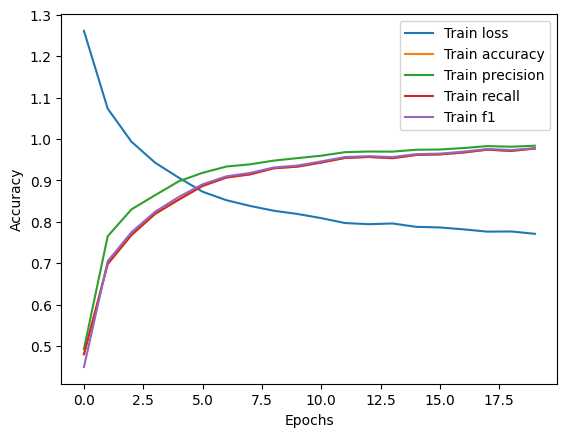

In [71]:
plt.plot(epochs_time, epochs_loss, label="Train loss")
plt.plot(epochs_time, epochs_acc_accuracy, label="Train accuracy")
plt.plot(epochs_time, epochs_acc_precision, label="Train precision")
plt.plot(epochs_time, epochs_acc_recall, label="Train recall")
plt.plot(epochs_time, epochs_acc_f1, label="Train f1")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

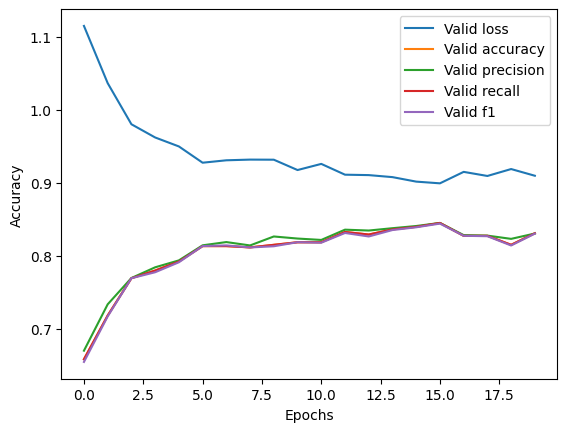

In [72]:
plt.plot(epochs_time, epochs_val_loss, label="Valid loss")
plt.plot(epochs_time, epochs_val_acc_accuracy, label="Valid accuracy")
plt.plot(epochs_time, epochs_val_acc_precision, label="Valid precision")
plt.plot(epochs_time, epochs_val_acc_recall, label="Valid recall")
plt.plot(epochs_time, epochs_val_acc_f1, label="Valid f1")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [73]:
model.eval()
test_acc_accuracy = []


pred_array = torch.Tensor([]).to(device)
array_label = torch.Tensor([]).to(device)
for x, y in test_iter:
#         print(123)
        array_text_link, array_video_link, array_audio_link= torch.Tensor([]).to(device), [], torch.Tensor([]).to(device)
        array_text_mean = torch.Tensor([]).to(device)
        img_face_first, img_face_last, img_face_mean = torch.Tensor([]).to(device), torch.Tensor([]).to(device), torch.Tensor([]).to(device)
        img_body_first, img_body_last, img_body_mean = torch.Tensor([]).to(device), torch.Tensor([]).to(device), torch.Tensor([]).to(device)
        key_face_first, key_face_last, key_face_mean = torch.Tensor([]).to(device), torch.Tensor([]).to(device), torch.Tensor([]).to(device)
        key_body_first, key_body_last, key_body_mean = torch.Tensor([]).to(device), torch.Tensor([]).to(device), torch.Tensor([]).to(device)
        context_first, context_last, context_mean = torch.Tensor([]).to(device), torch.Tensor([]).to(device), torch.Tensor([]).to(device)
        array_text = []
        for index in x:
#             audio_d = torch.Tensor(pd_audio_test[index[0].item()]).unsqueeze(0).to(device)
#             array_audio_link = torch.cat((array_audio_link, audio_d))
            
#             link_txt = test_text[index[0].item()]
#             link_txt = f"/kaggle/input/iemocap-clone/new_data/new_data/{link_txt}.txt"
#             f = open(link_txt, "r")
#             txt = f.read()
#             array_text.append(txt)
            
#             ==
            link_origin = test_text[index[0].item()]

            link_audio = f"/kaggle/input/iemocap-clone/new_data/new_data/{link_origin}.wav" 
            signal, fs = librosa.load(link_audio,  sr=16000)
            signal = torch.Tensor(signal)
            
#             if signal.shape[0] > 96000:
#                 signal = signal[signal.shape[0]-96000:signal.shape[0]]
#             signal = torch.cat((signal, torch.zeros(96000 - signal.shape[0])))
            if signal.shape[0] > 210000:
#                 signal = signal[210000:signal.shape[0]]
                signal = signal[signal.shape[0]-210000:signal.shape[0]]
#                 signal = signal[16000:210000+16000]
            signal = torch.cat((signal, torch.zeros(210000 - signal.shape[0])))
    
#             print(array_audio_link)
#             print("#####")
            array_audio_link = torch.cat((array_audio_link, signal.unsqueeze(0).to(device)))
            
#             link_txt = test_text[index[0].item()]
            link_txt = f"/kaggle/input/iemocap-clone/new_data/new_data/{link_origin}.txt"
            f = open(link_txt, "r")
            txt = f.read()
            array_text.append(txt)
#             text_d = torch.Tensor(pd_text_sos_test[index[0].item()]).unsqueeze(0).to(device)
#             array_text_link = torch.cat((array_text_link, text_d))
#             text_mean = torch.Tensor(pd_text_mean_test[index[0].item()]).unsqueeze(0).to(device)
#             array_text_mean = torch.cat((array_text_mean, text_mean))
            
            tra_img_face_first = torch.Tensor(test_img_face_first[index[0].item()]).unsqueeze(0).to(device)
            img_face_first = torch.cat((img_face_first, tra_img_face_first))
            
            tra_img_face_last = torch.Tensor(test_img_face_last[index[0].item()]).unsqueeze(0).to(device)
            img_face_last = torch.cat((img_face_last, tra_img_face_last))
            
            tra_img_face_mean =torch.Tensor(test_img_face_mean[index[0].item()]).unsqueeze(0).to(device)
            img_face_mean = torch.cat((img_face_mean, tra_img_face_mean))
            
            tra_img_body_first = torch.Tensor(test_img_body_first[index[0].item()]).unsqueeze(0).to(device)
            img_body_first = torch.cat((img_body_first, tra_img_body_first))
            
            tra_img_body_last = torch.Tensor(test_img_body_last[index[0].item()]).unsqueeze(0).to(device)
            img_body_last = torch.cat((img_body_last, tra_img_body_last))
            
            tra_img_body_mean = torch.Tensor(test_img_body_mean[index[0].item()]).unsqueeze(0).to(device)
            img_body_mean = torch.cat((img_body_mean, tra_img_body_mean))
            
            tra_key_face_first = torch.Tensor(test_key_face_first[index[0].item()]).unsqueeze(0).to(device)
            key_face_first = torch.cat((key_face_first, tra_key_face_first))
            
            tra_key_face_last = torch.Tensor(test_key_face_last[index[0].item()]).unsqueeze(0).to(device)
            key_face_last = torch.cat((key_face_last, tra_key_face_last))
            
            tra_key_face_mean = torch.Tensor(test_key_face_mean[index[0].item()]).unsqueeze(0).to(device)
            key_face_mean = torch.cat((key_face_mean, tra_key_face_mean))
            
            tra_key_body_first = torch.Tensor(test_key_body_first[index[0].item()]).unsqueeze(0).to(device)
            key_body_first = torch.cat((key_body_first, tra_key_body_first))
            
            tra_key_body_last = torch.Tensor(test_key_body_last[index[0].item()]).unsqueeze(0).to(device)
            key_body_last = torch.cat((key_body_last, tra_key_body_last))
            
            tra_key_body_mean = torch.Tensor(test_key_body_mean[index[0].item()]).unsqueeze(0).to(device)
            key_body_mean = torch.cat((key_body_mean, tra_key_body_mean))
            
            tra_context_first = torch.Tensor(test_context_first[index[0].item()]).unsqueeze(0).to(device)
            context_first = torch.cat((context_first, tra_context_first))
            
            tra_context_last = torch.Tensor(test_context_last[index[0].item()]).unsqueeze(0).to(device)
            context_last = torch.cat((context_last, tra_context_last))
            
            tra_context_mean = torch.Tensor(test_context_mean[index[0].item()]).unsqueeze(0).to(device)
            context_mean = torch.cat((context_mean, tra_context_mean))
        
        
        label_array =  F.one_hot(torch.Tensor(y).long(), num_classes = 4).float().to(device)
        array_label = torch.concat((array_label, label_array))
        array_text_link = tokenizer(array_text, return_tensors="pt", padding='max_length', truncation=True, max_length= 32)
        array_audio_link = processor(array_audio_link, sampling_rate=16000, return_tensors="pt")

        batch_all = label_array.shape[0]
        with torch.no_grad():
            pred = model(array_text_link.to(device), array_audio_link.to(device), array_text_mean.to(device),batch_all,
                    img_face_first.to(device), img_face_last.to(device), img_face_mean.to(device),
                    img_body_first.to(device), img_body_last.to(device), img_body_mean.to(device),
                    key_face_first.to(device), key_face_last.to(device), key_face_mean.to(device),
                    key_body_first.to(device), key_body_last.to(device), key_body_mean.to(device),
                    context_first.to(device), context_last.to(device), context_mean.to(device)
                    )
        pred_array = torch.cat((pred_array,pred),dim=0)
        
loss = loss_fn(pred_array, array_label)
accuracy, precision, recall, f1 = trie(array_label, pred_array)     
        
#         label_array =  F.one_hot(torch.Tensor(y).long(), num_classes = 4).float().to(device)
#         array_label = torch.cat((array_label, label_array))
# batch_all = array_label.shape[0]
# array_text_link = tokenizer(array_text, return_tensors="pt", padding='max_length', truncation=True, max_length= 32)

# pred = model(array_text_link, array_audio_link, array_text_mean, batch_all)
# pred = model(array_text_link.to(device), array_audio_link.to(device), array_text_mean.to(device),batch_all,
#                 img_face_first.to(device), img_face_last.to(device), img_face_mean.to(device),
#                 img_body_first.to(device), img_body_last.to(device), img_body_mean.to(device),
#                 key_face_first.to(device), key_face_last.to(device), key_face_mean.to(device),
#                 key_body_first.to(device), key_body_last.to(device), key_body_mean.to(device),
#                 context_first.to(device), context_last.to(device), context_mean.to(device)
#                 )
# loss = loss_fn(pred, array_label)
torch.cuda.empty_cache()
# accuracy, precision, recall, f1 = trie(array_label, pred)
print(f"loss: {loss.item()}")
print(f"accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"f1: {f1}")

loss: 0.9282253384590149
accuracy: 0.818342151675485
precision: 0.819984843332375
recall: 0.818342151675485
f1: 0.8182358124431384


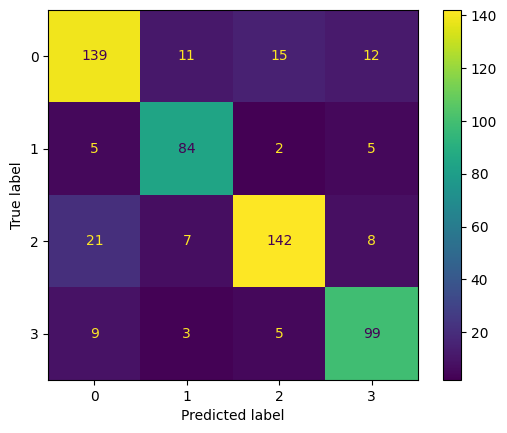

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
ground_truth = torch.argmax(torch.clone(array_label), dim=1).cpu().detach().numpy().copy()
pred_ind = torch.argmax( torch.clone(pred_array), dim=1).cpu().detach().numpy().copy()
cm = confusion_matrix(ground_truth, pred_ind)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()